# The Gerber statistic: a robust co-movement measure for portfolio optimization

The Gerber Statistic: A Robust Co-Movement Measure for Portfolio Optimization: [Link Here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3880054)

## Functions

These functions come from the computations that are in notebook. I worked on the computation in the notebook and then re-wrote them as functions that are held here. They are usually not called until I've already used the code.

In [1]:
def make_efficient_frontier(rtns, cov, num_portfolios):

    results_matrix = np.zeros((len(rtns) + 3, num_portfolios))
    for i in range(num_portfolios):

        if i % 10_000 == 0:
            print("working on portfolio num: {:,}".format(i))

        weights = np.random.random(len(rtns))
        weights /= np.sum(weights)
        port_rtn = np.sum(rtns * weights) * 252
        port_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
        sharpe_ratio = (port_rtn - rfr) / port_std

        results_matrix[0,i] = port_rtn
        results_matrix[1,i] = port_std 
        results_matrix[2,i] = sharpe_ratio

        for j in range(len(weights)): results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T, columns = ["ret", "stdev", "sharpe"] + rtns.index.to_list())
    
    return(results_df)

In [2]:
def make_gerber_corr(rtns, threshold_constant = 1/2, method = "method1"):
    
    hk = (rtns.std().reset_index().rename(
        columns = {0: "std_dev"}).
        assign(
            ck = threshold_constant,
            h_k = lambda x: x.ck * x.std_dev)
        [["ticker", "h_k"]])

    threshold_df = (rtns.reset_index().melt(
            id_vars = "Date").
            merge(hk, how = "outer", on = "ticker").
            rename(columns = {"value": "rtns"}))

    if method == "method1":

        combinations = list(itertools.combinations(rtns.columns.to_list(),2))
        m_ij = pd.DataFrame(columns = ["Date", "m_ij", "ticker1", "ticker2"]).set_index("Date")
        gerber_stat = pd.DataFrame(columns = ["ticker1", "ticker2", "gerber_stat"])

        for combo in combinations:

            returns_tmp = (threshold_df[["Date", "ticker", "rtns"]].query(
                "ticker == @combo[0] | ticker == @combo[1]").
                 pivot(index = "Date", columns = "ticker", values = "rtns").
                 rename(columns = 
                        {combo[0]: "{}_rtns".format(combo[0]), 
                         combo[1]: "{}_rtns".format(combo[1])}))

            hk_rtmp = (threshold_df[["Date", "ticker", "h_k"]].query(
                "ticker == @combo[0] | ticker == @combo[1]").
                 pivot(index = "Date", columns = "ticker", values = "h_k").
                 rename(columns = 
                       {combo[0]: "{}_hk".format(combo[0]), 
                        combo[1]: "{}_hk".format(combo[1])}))

            combined_tmp = returns_tmp.merge(hk_rtmp, how = "inner", on = "Date")

            combined_tmp.loc[
                (combined_tmp["{}_rtns".format(combo[0])] >= combined_tmp["{}_hk".format(combo[1])]) &
                (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]), 
                "m_ij"] = 1 

            combined_tmp.loc[
                (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[1])]) &
                (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]), 
                "m_ij"] = 1

            combined_tmp.loc[
                (combined_tmp["{}_rtns".format(combo[0])] >=  combined_tmp["{}_hk".format(combo[1])]) &
                (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]), 
                "m_ij"] = -1

            combined_tmp.loc[
                (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[1])]) &
                (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]), 
                "m_ij"] = -1

            combined_tmp = (combined_tmp.fillna(0)[["m_ij"]].assign(
                ticker1 = combo[0], 
                ticker2 = combo[1]))



            gerber_tmp = (pd.DataFrame(
                {"ticker1": [combo[0]],
                 "ticker2": [combo[1]],
                 "gerber_stat": 
                     [sum(combined_tmp["m_ij"]) / 
                      sum(abs(combined_tmp["m_ij"]))]
                }))

            gerber_stat = gerber_stat.append(gerber_tmp)
            m_ij = m_ij.append(combined_tmp)

        if len(gerber_stat.query("gerber_stat < 0")) > 0:
            print("Gerber Matrix is not positive-definite")

        else:
            gerber_stat = gerber_stat.assign(tuple_name = lambda x: x.ticker1 + "_" + x.ticker2)

        g_matrix = gerber_stat[["ticker1", "ticker2", "gerber_stat"]].pivot(index = "ticker1", columns = "ticker2", values = "gerber_stat")
        g_matrix[g_matrix.index[0]] = np.nan
        cols = g_matrix.columns.to_list()
        cols = cols[-1:] + cols[:-1]
        g_matrix = g_matrix[cols]
        g_matrix = g_matrix.append(pd.DataFrame(columns = g_matrix.columns, index = [g_matrix.columns[-1]]))
        g_matrix = g_matrix.fillna(g_matrix.T)
        np.fill_diagonal(g_matrix.values, 1)

    if method == "method2":

        R = threshold_df.rename(columns = {"h_k": "h_j"})
        U = R
        U.loc[(U["rtns"] >= U["h_j"]), "u_tj"] = 1
        U = U.fillna(0)[["Date", "ticker", "u_tj"]].pivot(index = "Date", columns = "ticker", values = "u_tj")

        D = R
        D.loc[(D["rtns"] <= - D["h_j"]), "d_tj"] = 1
        D = D.fillna(0)[["Date", "ticker", "d_tj"]].pivot(index = "Date", columns = "ticker", values = "d_tj")

        N_UU = U.T.dot(U)
        N_DD = D.T.dot(D)

        N_conc = N_UU + N_DD
        N_disc = U.T.dot(D) + D.T.dot(U)

        g_matrix = (N_conc - N_disc).divide(N_conc + N_disc)
        
    return g_matrix

In [3]:
def make_gerber_cov(rtns, threshold = 1/2, method = "method1"):
    
    corr = make_gerber_corr(rtns, threshold, method)
    std_vec = rtns.std()
    cov = pd.DataFrame(
        data = np.dot(np.diag(std_vec), np.dot(corr, np.diag(std_vec))),
        columns = corr.columns,
        index = corr.columns)
    
    return cov

## Packages 

In [4]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Collect Backend Data

In [5]:
import sys
sys.path.append("C:/Users/Diego/Desktop/app_dev/streamlit/backend_tools/data_manager/root")

from DataManager import *
data_manager = DataManager(equity_master_sample = True)

In [6]:
equity_master = data_manager.equity_master_sample.query("ticker_type == 'Adj Close'")[["Date", "ticker", "value", "rtns"]]

## Calculating $H_k$ threshold 

$H_k = cs_k$ <br>
where $c = \frac{1}{2}$ and $s_k$ is the standard deviation

In [7]:
std = equity_master.drop(columns = ["value"]).groupby("ticker").agg(["std"])
std.columns = std.columns.droplevel()
std = std.reset_index().rename(columns = {"std": "std_dev"})

In [8]:
threshold_df = (equity_master.merge(
    std, how = "outer", on = "ticker").
    assign(
        c = 1/2,
        h_k = lambda x: x.c * x.std_dev))

In [9]:
combinations = list(itertools.combinations(threshold_df["ticker"].drop_duplicates().to_list(),2))

We need to work out the cases for each tuple

$
m_{ij}(t) = 
\begin{cases}
1 \; \textrm{if} \; r_{ti} \geq H_i \; \textrm{and} \; r_{tj} \geq H_j\\
1 \; \textrm{if} \; r_{ti} \leq -H_i \; \textrm{and} \; r_{tj} \leq - H_j\\
-1 \; \textrm{if} \; r_{ti} \geq H_i \; \textrm{and} \; r_{tj} \leq -H_j\\
-1 \; \textrm{if} \; r_{ti} \leq -H_i \; \textrm{and} \; r_{tj} \geq 1 H_j \\ 
0 \; \textrm{otherwise}
\end{cases}$

In [10]:
m_ij = pd.DataFrame(columns = ["Date", "m_ij", "ticker1", "ticker2"]).set_index("Date")
gerber_stat = pd.DataFrame(columns = ["ticker1", "ticker2", "gerber_stat"])

for combo in combinations:
    
    returns_tmp = (threshold_df[["Date", "ticker", "rtns"]].query(
        "ticker == @combo[0] | ticker == @combo[1]").
         pivot(index = "Date", columns = "ticker", values = "rtns").
         rename(columns = 
                {combo[0]: "{}_rtns".format(combo[0]), 
                 combo[1]: "{}_rtns".format(combo[1])}))
    
    hk_rtmp = (threshold_df[["Date", "ticker", "h_k"]].query(
        "ticker == @combo[0] | ticker == @combo[1]").
         pivot(index = "Date", columns = "ticker", values = "h_k").
         rename(columns = 
               {combo[0]: "{}_hk".format(combo[0]), 
                combo[1]: "{}_hk".format(combo[1])}))
    
    combined_tmp = returns_tmp.merge(hk_rtmp, how = "inner", on = "Date")
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] >= combined_tmp["{}_hk".format(combo[1])]) &
        (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]), 
        "m_ij"] = 1 
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[1])]) &
        (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]), 
        "m_ij"] = 1
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] >=  combined_tmp["{}_hk".format(combo[1])]) &
        (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]), 
        "m_ij"] = -1
    
    combined_tmp.loc[
        (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[1])]) &
        (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]), 
        "m_ij"] = -1
    
    combined_tmp = (combined_tmp.fillna(0)[["m_ij"]].assign(
        ticker1 = combo[0], 
        ticker2 = combo[1]))
    
    
    
    gerber_tmp = (pd.DataFrame(
        {"ticker1": [combo[0]],
         "ticker2": [combo[1]],
         "gerber_stat": 
             [sum(combined_tmp["m_ij"]) / 
              sum(abs(combined_tmp["m_ij"]))]
        }))
    
    gerber_stat = gerber_stat.append(gerber_tmp)
    m_ij = m_ij.append(combined_tmp)
    
if len(gerber_stat.query("gerber_stat < 0")) > 0:
    print("Gerber Matrix is not positive-definite")
    
else:
    gerber_stat = gerber_stat.assign(tuple_name = lambda x: x.ticker1 + "_" + x.ticker2)

## Construct Gerber Matrix (Method 1)

This method is using

$g_{ij} = \frac{\sum_{t = 1}^T m_{ij}(t)}{\sum_{t = 1}^T |m_{ij}(t)|}$

In [11]:
gerber_matrix = gerber_stat[["ticker1", "ticker2", "gerber_stat"]].pivot(index = "ticker1", columns = "ticker2", values = "gerber_stat")

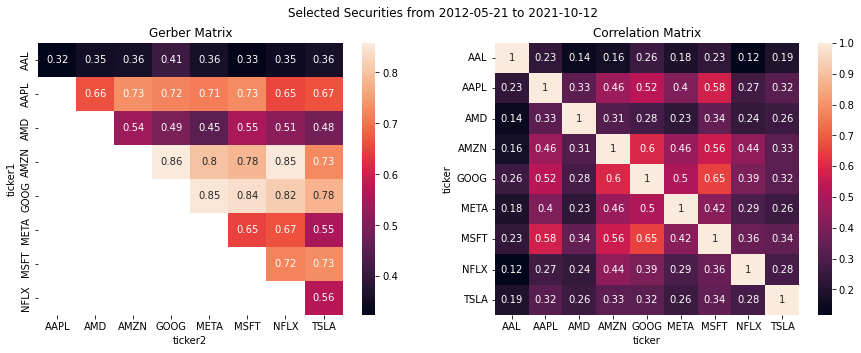

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

sns.heatmap(gerber_matrix, annot = True, ax = axes[0])
axes[0].set_title("Gerber Matrix")

sns.heatmap(
    equity_master[["Date", "ticker", "rtns"]].pivot(index = "Date", columns = "ticker", values = "rtns").corr(),
    annot = True,
    ax = axes[1])
axes[1].set_title("Correlation Matrix")

fig.suptitle("Selected Securities from {} to {}".format(equity_master.Date.min().date(), equity_master.Date.max().date()))
plt.show()

## Constructing Gerber Matrix via Cocordant and Discordant Matrices (Method 2)

$G = (N_{CONC} - N_{DISC} ) \; / \; (N_{CONC} + N_{DISC} ) \; \textrm{Element-wise}$

$u_{tj} = 
\begin{cases}
1 \; \textrm{if} \; r_{tj} \geq H_j\\
0 \; \textrm{otherwise}
\end{cases}$

$d_{tj} = 
\begin{cases}
1 \; \textrm{if} \; r_{tj} \leq - H_j\\
0 \; \textrm{otherwise}
\end{cases}$

In [13]:
std = equity_master.drop(columns = ["value"]).groupby("ticker").agg(["std"])
std.columns = std.columns.droplevel()
std = std.reset_index().rename(columns = {"std": "std_dev"})

In [14]:
R = (equity_master[["Date", "ticker", "rtns"]].merge(
    std, on = "ticker").
    assign(
        c = 1/2,
        h_j = lambda x: x.std_dev * x.c))

In [15]:
U = R
U.loc[(U["rtns"] >= U["h_j"]), "u_tj"] = 1
U = U.fillna(0)[["Date", "ticker", "u_tj"]].pivot(index = "Date", columns = "ticker", values = "u_tj")

In [16]:
D = R
D.loc[(D["rtns"] <= - D["h_j"]), "d_tj"] = 1
D = D.fillna(0)[["Date", "ticker", "d_tj"]].pivot(index = "Date", columns = "ticker", values = "d_tj")

$ N^{UU} = U^\intercal U$

$N^{DD} = D^\intercal D$

In [17]:
N_UU = U.T.dot(U)
N_DD = D.T.dot(D)

$
N_{CONC} = N^{UU} + N^{DD} = U^\intercal U + D^\intercal D
$

In [18]:
N_conc = N_UU + N_DD

$
N_{DISC} = U^\intercal D + D^\intercal U
$

In [19]:
N_disc = U.T.dot(D) + D.T.dot(U)

$G = (N_{CONC} - N_{DISC} ) \; / \; (N_{CONC} + N_{DISC} ) \; \textrm{Element-wise}$

In [20]:
G = (N_conc - N_disc).divide(N_conc + N_disc)

In [21]:
gerber_matrix[gerber_matrix.index[0]] = np.nan
cols = gerber_matrix.columns.to_list()
cols = cols[-1:] + cols[:-1]
gerber_matrix = gerber_matrix[cols]
gerber_matrix = gerber_matrix.append(pd.DataFrame(columns = gerber_matrix.columns, index = [gerber_matrix.columns[-1]]))
gerber_matrix = gerber_matrix.fillna(gerber_matrix.T)
np.fill_diagonal(gerber_matrix.values, 1)

## Plots

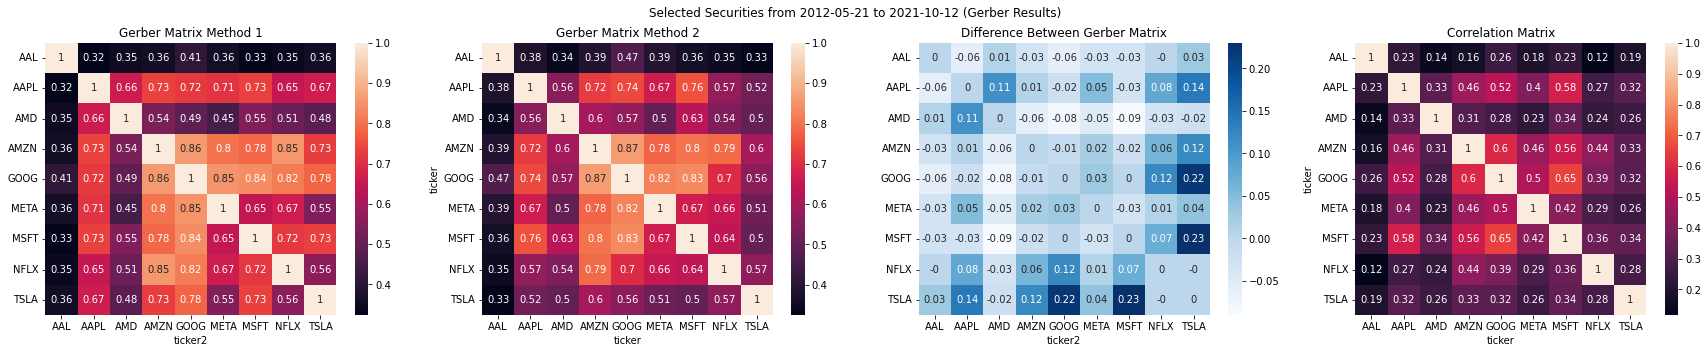

In [22]:
fig, axes = plt.subplots(1, 4, figsize = (30, 5))

sns.heatmap(
    data = gerber_matrix,
    annot = True,
    ax = axes[0])
axes[0].set_title("Gerber Matrix Method 1")

sns.heatmap(
    data = G,
    annot = True,
    ax = axes[1])
axes[1].set_title("Gerber Matrix Method 2")

sns.heatmap(
    data = round((gerber_matrix - G),2),
    annot = True,
    cmap = "Blues",
    ax = axes[2])
axes[2].set_title("Difference Between Gerber Matrix")

sns.heatmap(
    data = equity_master[["Date", "ticker", "rtns"]].pivot(index = "Date", columns = "ticker", values = "rtns").corr(),
    annot = True,
    ax = axes[3])
axes[3].set_title("Correlation Matrix")

fig.suptitle("Selected Securities from {} to {} (Gerber Results)".format(equity_master.Date.min().date(), equity_master.Date.max().date()))
plt.show()

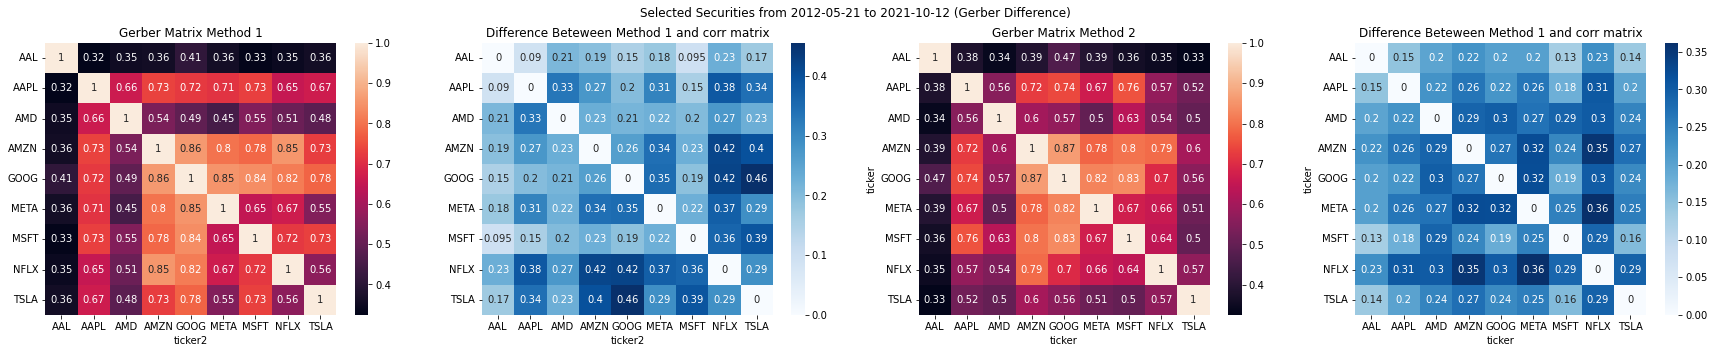

In [23]:
fig, axes = plt.subplots(1, 4, figsize = (30, 5))

sns.heatmap(
    data = gerber_matrix,
    annot = True,
    ax = axes[0])
axes[0].set_title("Gerber Matrix Method 1")

sns.heatmap(
    data = (gerber_matrix - equity_master[["Date", "ticker", "rtns"]].pivot(index = "Date", columns = "ticker", values = "rtns").corr()),
    cmap = "Blues",
    annot = True,
    ax = axes[1])
axes[1].set_title("Difference Beteween Method 1 and corr matrix")

sns.heatmap(
    data = G,
    annot = True,
    ax = axes[2])
axes[2].set_title("Gerber Matrix Method 2")

sns.heatmap(
    data = (G - equity_master[["Date", "ticker", "rtns"]].pivot(index = "Date", columns = "ticker", values = "rtns").corr()),
    cmap = "Blues",
    annot = True,
    ax = axes[3])
axes[3].set_title("Difference Beteween Method 1 and corr matrix")

fig.suptitle("Selected Securities from {} to {} (Gerber Difference)".format(equity_master.Date.min().date(), equity_master.Date.max().date()))
plt.show()

## Constructing Geber Covariance Matrix (Method 1)

Normal Covariance Matrix

In [24]:
sample_cov = equity_master[["Date", "ticker", "rtns"]].pivot(index = "Date", columns = "ticker", values = "rtns").cov()

$\Sigma_{GS} = diag(\vec{\sigma}) \; G \; daig(\vec{\sigma})$

In [25]:
sigma = (equity_master[["Date", "ticker", "rtns"]].pivot(
    index = "Date", columns = "ticker", values = "rtns").
    agg("std"))

In [26]:
cov1 = round(pd.DataFrame(
    np.dot(np.diag(sigma), gerber_matrix, np.diag(sigma)),
    columns = gerber_matrix.columns,
    index = gerber_matrix.columns),2)

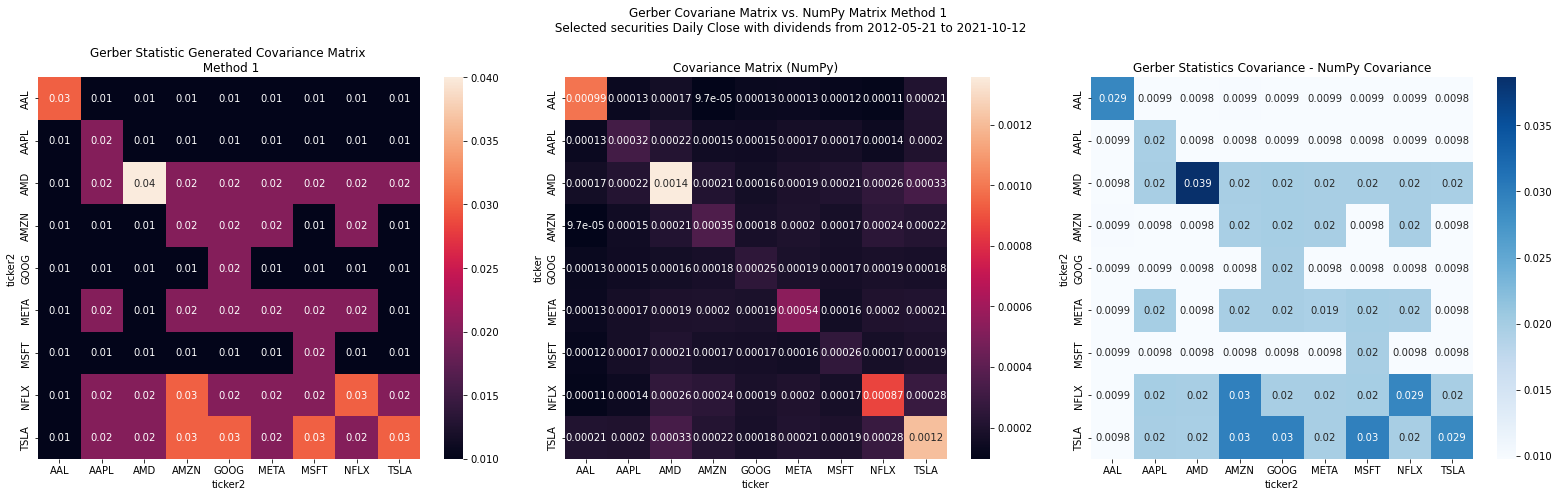

In [27]:
fig, axes = plt.subplots(1, 3, figsize = (22, 7))

sns.heatmap(
    ax = axes[0],
    data = cov1, 
    annot = True)
axes[0].set_title("Gerber Statistic Generated Covariance Matrix \n Method 1")

sns.heatmap(
    ax = axes[1],
    data = sample_cov,
    annot = True)
axes[1].set_title("Covariance Matrix (NumPy)")

sns.heatmap(
    ax = axes[2],
    data = cov1 - sample_cov,
    annot = True,
    cmap = "Blues")
axes[2].set_title("Gerber Statistics Covariance - NumPy Covariance")

plt.suptitle("Gerber Covariane Matrix vs. NumPy Matrix Method 1\n Selected securities Daily Close with dividends from {} to {}".format(equity_master.Date.min().date(), equity_master.Date.max().date()))
plt.tight_layout()
plt.show()

## Constructing Geber Covariance Matrix (Method 2)

$\Sigma_{GS} = diag(\vec{\sigma}) \; G \; daig(\vec{\sigma})$

In [28]:
cov2 = round(pd.DataFrame(
    np.dot(np.diag(sigma), G, np.diag(sigma)),
    columns = G.columns,
    index = G.columns),2)

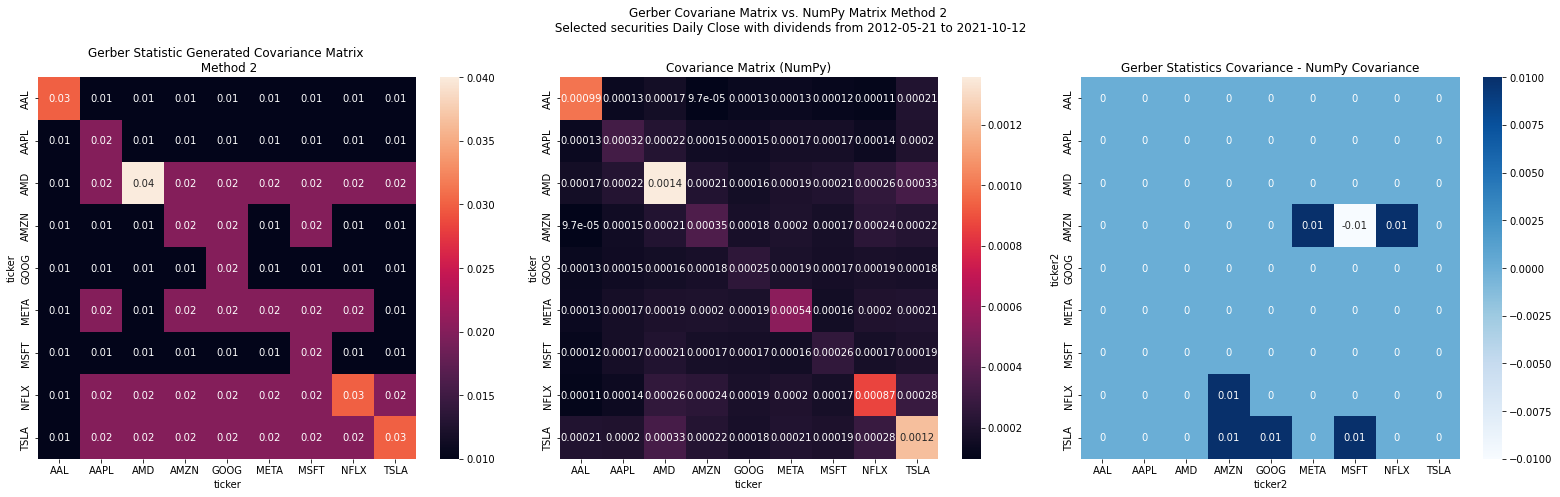

In [29]:
fig, axes = plt.subplots(1, 3, figsize = (22, 7))

sns.heatmap(
    ax = axes[0],
    data = cov2, 
    annot = True)
axes[0].set_title("Gerber Statistic Generated Covariance Matrix \n Method 2")

sns.heatmap(
    ax = axes[1],
    data = sample_cov,
    annot = True)
axes[1].set_title("Covariance Matrix (NumPy)")

sns.heatmap(
    ax = axes[2],
    data = cov1 - cov2,
    annot = True,
    cmap = "Blues")
axes[2].set_title("Gerber Statistics Covariance - NumPy Covariance")

plt.suptitle("Gerber Covariane Matrix vs. NumPy Matrix Method 2\n Selected securities Daily Close with dividends from {} to {}".format(equity_master.Date.min().date(), equity_master.Date.max().date()))
plt.tight_layout()
plt.show()

## Sample Mean Markowitz

In [30]:
rtns = equity_master[["Date", "ticker", "rtns"]].pivot(index = "Date", columns = "ticker", values = "rtns").mean()
num_portfolios = 100_000
cov = cov1
rfr = 0.01

In [31]:
results_matrix = np.zeros((len(rtns) + 3, num_portfolios))
for i in range(num_portfolios):
    
    if i % 10_000 == 0:
        print("working on portfolio num: {:,}".format(i))
    
    weights = np.random.random(len(rtns))
    weights /= np.sum(weights)
    port_rtn = np.sum(rtns * weights) * 252
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov1, weights))) * np.sqrt(252)
    sharpe_ratio = (port_rtn - rfr) / port_std
    
    results_matrix[0,i] = port_rtn
    results_matrix[1,i] = port_std 
    results_matrix[2,i] = sharpe_ratio
    
    for j in range(len(weights)): results_matrix[j+3,i] = weights[j]
    
results_df = pd.DataFrame(results_matrix.T, columns = ["ret", "stdev", "srhape"] + equity_master.ticker.drop_duplicates().to_list())

working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000


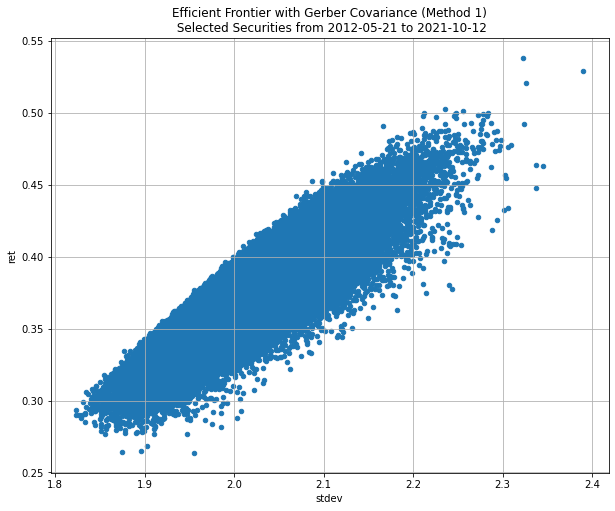

In [32]:
results_df.plot(
    kind = "scatter", x = "stdev", y = "ret",
    grid = True,
    title = "Efficient Frontier with Gerber Covariance (Method 1)\n Selected Securities from {} to {}".format(equity_master.Date.min().date(), equity_master.Date.max().date()),
    figsize = (10,8))
plt.show()

## Let's try and select different securities and different time frame

In [33]:
data_manager = DataManager(equity_master = True)

In [34]:
ticker_list = ["AAPL", "MSFT", "NFLX", "AMZN", "GOOG", "META"]

In [35]:
equity_master = (data_manager.equity_master.query(
    "ticker_type == 'Adj Close' & Date > '2010-01-01' & Date < '2018-01-01' & ticker == @ticker_list").
    drop(columns = ["ticker_type"]))

In [36]:
rtns = equity_master.pivot(index = "Date", columns = "ticker", values = "value").dropna().pct_change().dropna()

In [37]:
corr_np = rtns.corr()
corr_method1 = make_gerber_corr(rtns)
corr_method2 = make_gerber_corr(rtns, method = "method2")

cov_np = rtns.cov()
cov_method1 = make_gerber_cov(rtns)
cov_method2 = make_gerber_cov(rtns, method = "method2")

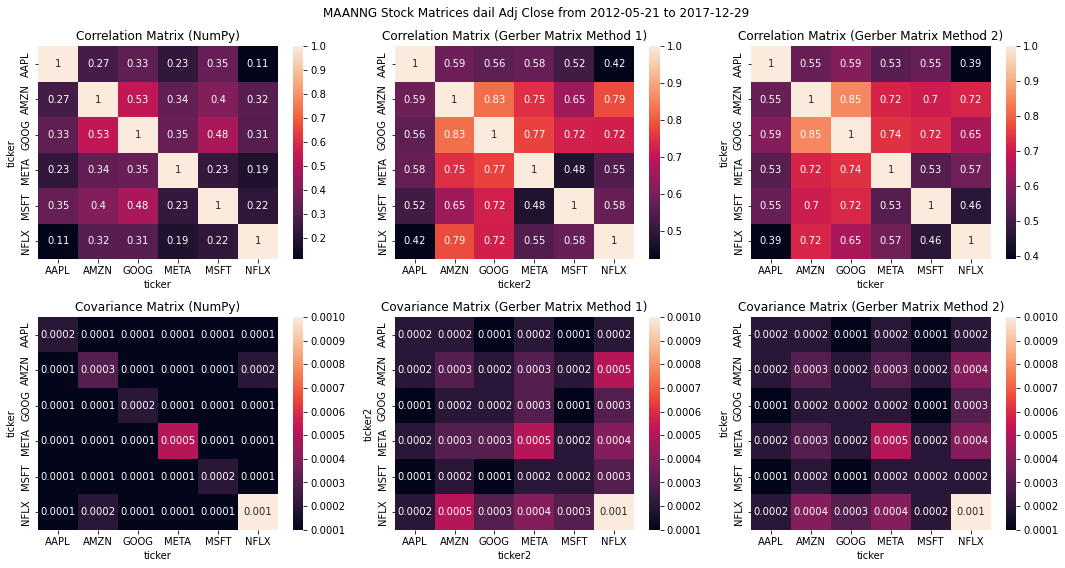

In [38]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
plot_info = [
    (corr_np, "Correlation Matrix (NumPy)", axes[0,0]),
    (corr_method1, "Correlation Matrix (Gerber Matrix Method 1)", axes[0,1]),
    (corr_method2, "Correlation Matrix (Gerber Matrix Method 2)", axes[0,2]),
    (cov_np, "Covariance Matrix (NumPy)", axes[1,0]),
    (cov_method1, "Covariance Matrix (Gerber Matrix Method 1)", axes[1,1]),
    (cov_method2, "Covariance Matrix (Gerber Matrix Method 2)", axes[1,2])]


for i in range(len(plot_info)):
    
    data = plot_info[i][0]
    title = plot_info[i][1]
    axes = plot_info[i][2]
    
    sns.heatmap(
        data = round(data,4),
        annot = True,
        ax = axes)
    axes.set_title(title)

plt.suptitle("MAANNG Stock Matrices dail Adj Close from {} to {}".format(rtns.index.min().date(), rtns.index.max().date()))
plt.tight_layout()
plt.show()

In [39]:
efficient_frontier_numpy = make_efficient_frontier(rtns.mean(), cov_np, 100_000)

working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000


In [40]:
efficient_frontier_gerber1 = make_efficient_frontier(rtns.mean(), cov_method1, 100_000)

working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000


In [41]:
efficient_frontier_gerber2 = make_efficient_frontier(rtns.mean(), cov_method2, 100_000)

working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000


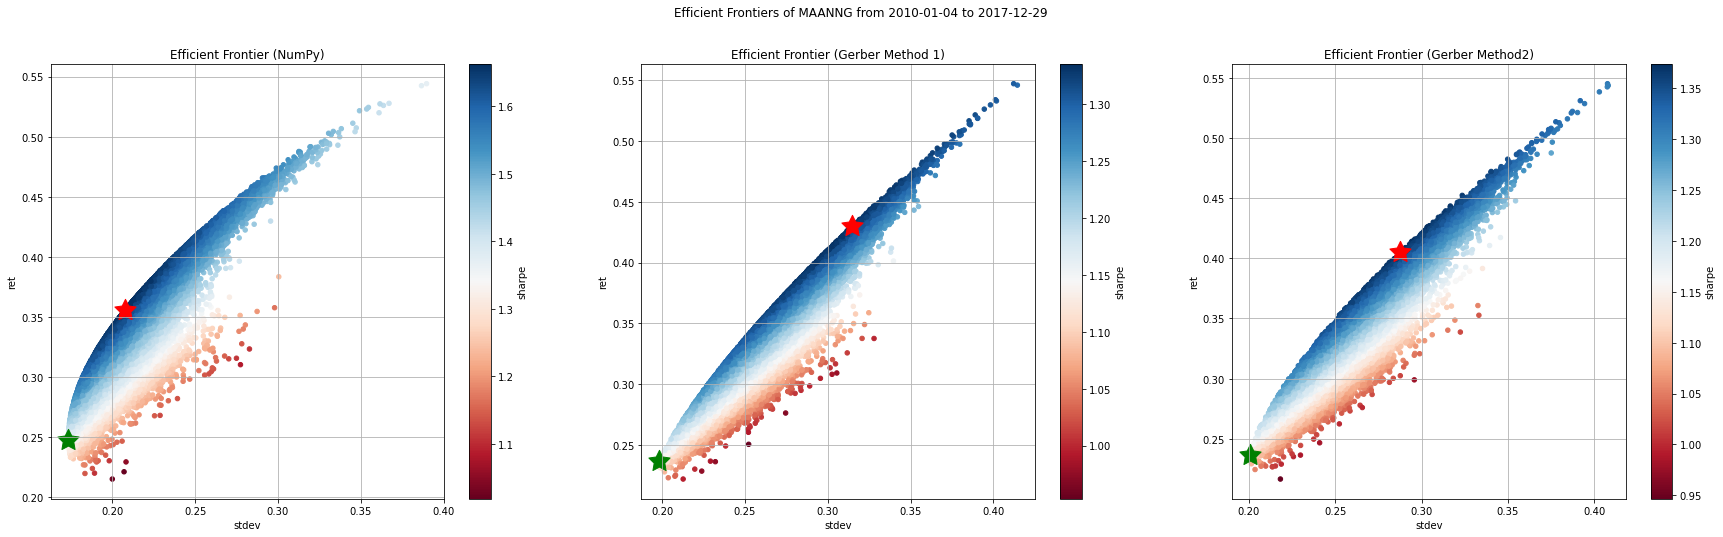

In [42]:
fig, axes = plt.subplots(1, 3, figsize = (30,8))

efficient_frontier_numpy.plot(
    kind = "scatter", x = "stdev", y = "ret", c = "sharpe",
    cmap= "RdBu",
    title = "Efficient Frontier (NumPy)",
    grid = True,
    ax = axes[0])

max_sharpe_port = efficient_frontier_numpy.iloc[efficient_frontier_numpy['sharpe'].idxmax()]
min_vol_port = efficient_frontier_numpy.iloc[efficient_frontier_numpy['stdev'].idxmin()]
axes[0].scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5,1,0), color='r', s=500)
axes[0].scatter(min_vol_port[1], min_vol_port[0], marker=(5,1,0), color='g', s=500)

efficient_frontier_gerber1.plot(
    kind = "scatter", x = "stdev", y = "ret", c = "sharpe",
    cmap = "RdBu",
    title = "Efficient Frontier (Gerber Method 1)",
    grid = True,
    ax = axes[1])

max_sharpe_port = efficient_frontier_gerber1.iloc[efficient_frontier_gerber1['sharpe'].idxmax()]
min_vol_port = efficient_frontier_gerber1.iloc[efficient_frontier_gerber1['stdev'].idxmin()]
axes[1].scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5,1,0), color='r', s=500)
axes[1].scatter(min_vol_port[1], min_vol_port[0], marker=(5,1,0), color='g', s=500)

efficient_frontier_gerber2.plot(
    kind = "scatter", x = "stdev", y = "ret", c = "sharpe",
    cmap = "RdBu",
    title = "Efficient Frontier (Gerber Method2)",
    grid = True,
    ax = axes[2])

max_sharpe_port = efficient_frontier_gerber2.iloc[efficient_frontier_gerber2['sharpe'].idxmax()]
min_vol_port = efficient_frontier_gerber2.iloc[efficient_frontier_gerber2['stdev'].idxmin()]
axes[2].scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5,1,0), color='r', s=500)
axes[2].scatter(min_vol_port[1], min_vol_port[0], marker=(5,1,0), color='g', s=500)

plt.suptitle("Efficient Frontiers of MAANNG from {} to {}".format(equity_master.Date.min().date(), equity_master.Date.max().date()))
plt.show()

## Avoid Dimensionality with 4 tickers: SPY, QQQ, HYG, AGG

In [43]:
data_manager = DataManager(fund_master = True)

In [44]:
fund_master = data_manager.fund_master

In [45]:
tickers = ["SPY", "QQQ", "HYG", "AGG"]
rtns = (fund_master.query(
    "ticker_type == 'Adj Close' & ticker == @tickers & Date > '2010-01-01' & Date < '2018-01-01'")
    [["Date", "ticker", "value"]].
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change().dropna())

In [46]:
cov_np = rtns.cov()
cov_method1 = make_gerber_cov(rtns)
cov_method2 = make_gerber_cov(rtns, method = "method2")

Gerber Matrix is not positive-definite


In [47]:
efficient_frontier_numpy = make_efficient_frontier(rtns.mean(), cov_np, 100_000)
efficient_frontier_gerber1 = make_efficient_frontier(rtns.mean(), cov_method1, 100_000)
efficient_frontier_gerber2 = make_efficient_frontier(rtns.mean(), cov_method2, 100_000)

working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000
working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000
working on portfolio num: 0
working on portfolio num: 10,000
working on portfolio num: 20,000
working on portfolio num: 30,000
working on portfolio num: 40,000
working on portfolio num: 50,000
working on portfolio num: 60,000
working on portfolio num: 70,000
working on portfolio num: 80,000
working on portfolio num: 90,000


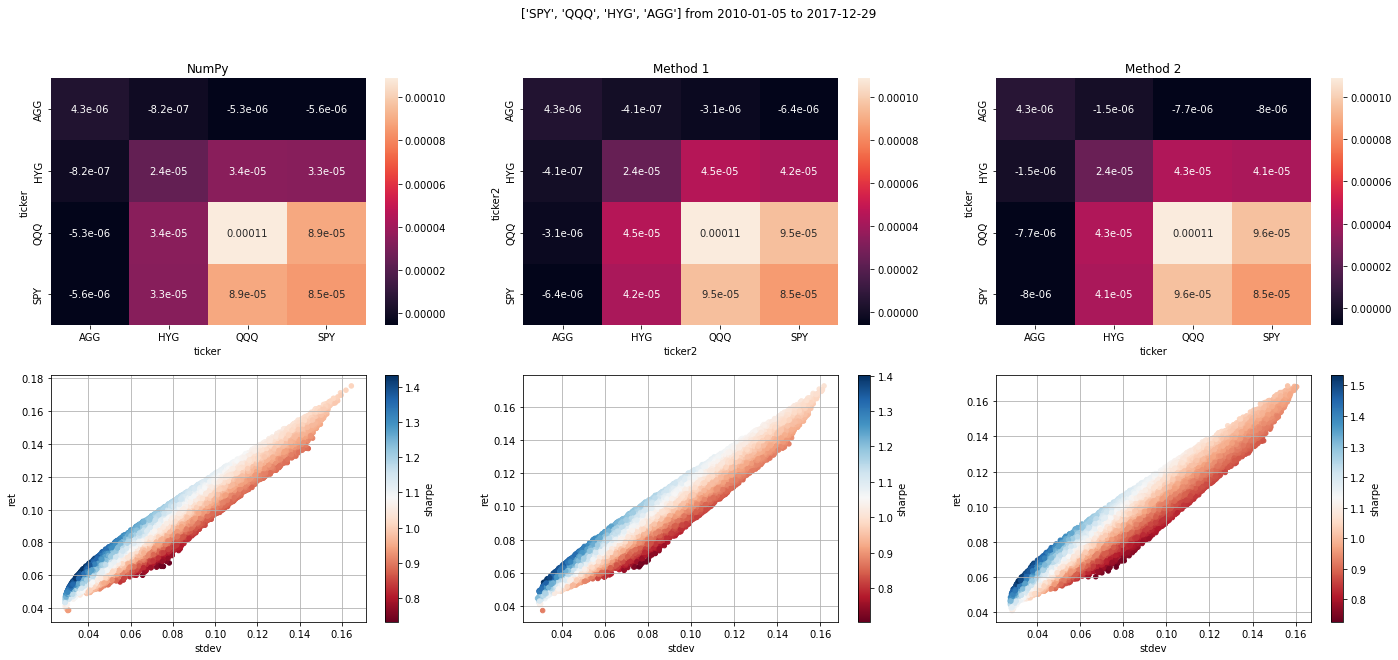

In [48]:
fig, axes = plt.subplots(2, 3, figsize = (24,10))

sns.heatmap(
    data = cov_np,
    ax = axes[0,0],
    annot = True)
axes[0,0].set_title("NumPy")

sns.heatmap(
    data = cov_method1,
    ax = axes[0,1],
    annot = True)
axes[0,1].set_title("Method 1")

sns.heatmap(
    data = cov_method2,
    ax = axes[0,2],
    annot = True)
axes[0,2].set_title("Method 2")

efficient_frontier_numpy.plot(
    kind = "scatter", x = "stdev", y = "ret",
    ax = axes[1,0],
    c = "sharpe", cmap = "RdBu",
    grid = True)

efficient_frontier_gerber1.plot(
    kind = "scatter", x = "stdev", y = "ret",
    ax = axes[1,1],
    c = "sharpe", cmap = "RdBu",
    grid = True)

efficient_frontier_gerber2.plot(
    kind = "scatter", x = "stdev", y = "ret",
    ax = axes[1,2],
    c = "sharpe", cmap = "RdBu",
    grid = True)

plt.suptitle("{} from {} to {}".format(tickers, rtns.index.min().date(), rtns.index.max().date()))
plt.show()